In [1]:
import torch
import pythoncom
from win32com.client import Dispatch, gencache

def get_kompas_api7():
    # module = gencache.EnsureModule("{69AC2981-37C0-4379-84FD-5DD2F3C0A520}", 0, 1, 0)
    # api = module.IKompasAPIObject(
    #     Dispatch("Kompas.Application.7")._oleobj_.QueryInterface(module.IKompasAPIObject.CLSID,
    #                                                              pythoncom.IID_IDispatch))
    # return module, api
    try:
        module = gencache.EnsureModule("{69AC2981-37C0-4379-84FD-5DD2F3C0A520}", 0, 1, 0)
        api = module.IKompasAPIObject(
            Dispatch("Kompas.Application.7")._oleobj_.QueryInterface(module.IKompasAPIObject.CLSID,
                                                                     pythoncom.IID_IDispatch))
        return module, api
    except Exception as e:
        print(f"Error: {e}")
        return None, None

def get_kompas_api5():
    module = gencache.EnsureModule("{0422828C-F174-495E-AC5D-D31014DBBE87}", 0, 1, 0)
    api = module.KompasObject(            
        Dispatch("Kompas.Application.5")._oleobj_.QueryInterface(module.KompasObject.CLSID,                                                        
                                                                 pythoncom.IID_IDispatch))   
    return module, api

def get_constants():
    const = gencache.EnsureModule("{75C9F5D0-B5B8-4526-8681-9903C567D2ED}", 0, 1, 0).constants
    const_3d = gencache.EnsureModule("{2CAF168C-7961-4B90-9DA2-701419BEEFE3}", 0, 1, 0).constants
    return const, const_3d

module7, api7 = get_kompas_api7()   # Подключаемся к API7 
module5, api5 = get_kompas_api5()   # Подключаемся к API5 
const, const_3d = get_constants()
app7 = api7.Application                     # Получаем основной интерфейс
app7.Visible = True                         # Показываем окно пользователю (если скрыто)
app7.HideMessage = const.ksHideMessageNo   # Отвечаем НЕТ на любые вопросы программы

#  Подключим константы API Компас
kompas6_constants = gencache.EnsureModule("{75C9F5D0-B5B8-4526-8681-9903C567D2ED}", 0, 1, 0).constants
kompas6_constants_3d = gencache.EnsureModule("{2CAF168C-7961-4B90-9DA2-701419BEEFE3}", 0, 1, 0).constants

#  Подключим описание интерфейсов API5
kompas6_api5_module = gencache.EnsureModule("{0422828C-F174-495E-AC5D-D31014DBBE87}", 0, 1, 0)
kompas_object = kompas6_api5_module.KompasObject(Dispatch("Kompas.Application.5")._oleobj_.QueryInterface(kompas6_api5_module.KompasObject.CLSID, pythoncom.IID_IDispatch))

#  Подключим описание интерфейсов API7
kompas_api7_module = gencache.EnsureModule("{69AC2981-37C0-4379-84FD-5DD2F3C0A520}", 0, 1, 0)
application = kompas_api7_module.IApplication(Dispatch("Kompas.Application.7")._oleobj_.QueryInterface(kompas_api7_module.IApplication.CLSID, pythoncom.IID_IDispatch))

Documents = application.Documents

In [ ]:
### Проверка работоспособности метода преобразования модели в граф - можно пропустить
import os
path = os.getcwd() + "\\DSet\\"
files = os.listdir(path)
print(files)
filePath = os.path.join(path, files[1])
files = os.listdir(filePath)
filePath = os.path.join(filePath, files[1])
filePath

['filesK', 'korp_73', 'lists_74', 'Spins_71']


'c:\\u4ebaENG\\Diplom-\\DSet\\korp_73\\cob1_0.m3d.bak'

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def model_to_graph(filePath):
    kompas_document = Documents.Open(filePath, True, False)
    if kompas_document is None:
        raise Exception(f"Не удалось открыть файл: {filePath}")
    # Инициализируем граф NetworkX
    G = nx.DiGraph()
    iDocument3D = api5.ActiveDocument3D()
    kompas_document_3d = module7.IKompasDocument3D(kompas_document)
    iPart7 = kompas_document_3d.TopPart
    iPart = iDocument3D.GetPart(const_3d.pTop_Part)


    faces = iPart.EntityCollection(0)

    for j in range (faces.GetCount()):
        entity = faces.GetByIndex(j)
        if entity != None:
            if entity.type == 6: # если поверхность
                entity.name = 'F_' + str(j)
            if entity.type == 7: # если ребро
                entity.name = 'E_' + str(j)
            if entity.type == 8: # если вершина
                entity.name = 'V_' + str(j)

    def get_entity(num):
        entity = faces.GetByIndex(num)
        if entity != None:
            if entity.type == 6: # если поверхность
                face = entity.GetDefinition()
                connected= face.ConnectedFaceCollection()
                # Добавляем грань как основной узел
                G.add_node(entity.name, type="face")
                for c in range(connected.GetCount()):
                    conFace = connected.GetByIndex (c)
                    if conFace.GetEntity().name == '':
                        print('!!')
                    if not G.has_edge(entity.name, conFace.GetEntity().name):  # Проверяем, нет ли уже такого ребра
                        G.add_edge(entity.name, conFace.GetEntity().name)

    for j in range (faces.GetCount()):
        get_entity(j)
    
    kompas_document.Close(False)
    return G

In [ ]:
#не нужное
G = nx.DiGraph()

iDocument3D = api5.ActiveDocument3D()
kompas_document_3d = module7.IKompasDocument3D(kompas_document)
iPart7 = kompas_document_3d.TopPart
iPart = iDocument3D.GetPart(const_3d.pTop_Part)


faces = iPart.EntityCollection(0)

for j in range (faces.GetCount()):
    entity = faces.GetByIndex(j)
    if entity != None:
        if entity.type == 6: # если поверхность
            entity.name = 'F_' + str(j)
        if entity.type == 7: # если ребро
            entity.name = 'E_' + str(j)
        if entity.type == 8: # если вершина
            entity.name = 'V_' + str(j)

def get_entity(num):
    entity = faces.GetByIndex(num)
    if entity != None:
        if entity.type == 6: # если поверхность
            face = entity.GetDefinition()
            connected= face.ConnectedFaceCollection()
            # Добавляем грань как основной узел
            G.add_node(entity.name, type="face")
            for c in range(connected.GetCount()):
                conFace = connected.GetByIndex (c)
                if conFace.GetEntity().name == '':
                    print('!!')
                if not G.has_edge(entity.name, conFace.GetEntity().name):  # Проверяем, нет ли уже такого ребра
                    G.add_edge(entity.name, conFace.GetEntity().name)

for j in range (faces.GetCount()):
    get_entity(j)
      # Связываем грань с гранью
            
# Визуализация графа с помощью Matplotlib
plt.figure(figsize=(12, 10))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "face"]

nx.draw(G, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

In [3]:
### Проверка работоспособности вывода графа - можно пропустить
print(filePath)
G1 = model_to_graph(filePath)

plt.figure(figsize=(12, 10))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G1)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G1.nodes(data=True) if data["type"] == "face"]

nx.draw(G1, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

NameError: name 'filePath' is not defined

In [4]:
import torch_geometric
from torch_geometric.utils import from_networkx

def graph_to_data(G: nx.Graph, label: int = None) -> torch_geometric.data.Data:
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G = G.subgraph(largest_scc).copy()
    
    degrees = [val for _, val in G.degree()]
    closeness = list(nx.closeness_centrality(G).values())
    betweenness = list(nx.betweenness_centrality(G).values())
    pagerank = list(nx.pagerank(G).values())
    eccentricity = list(nx.eccentricity(G).values())
    
    features = torch.tensor(
        [[d, c, b, p, e] for d, c, b, p, e in zip(degrees, closeness, betweenness, pagerank, eccentricity)],
        dtype=torch.float
    )

    data = from_networkx(G)

    data.x = features
    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data

In [ ]:
### Проверка работоспособности преобразования графа в данные - можно пропустить
data = graph_to_data(G1, 2)
data.x

In [54]:
### Наполнение датасета данными преобразованными из моделей - стоит пропустить
 
from pandas import read_csv
import time, os
dataset = []
df_path = os.path.join(os.getcwd(), "dataset.csv")
df = read_csv(df_path)
folders = os.listdir(os.path.join(os.getcwd(), "DSet"))
folders.remove('filesK')
i=0
for f in folders:
    for idx, row in df.iterrows():
        try:
            filename = row["filename"]
            if row["label"] == i: 
                label = row["label"]
            else:
                continue
            
            modelPath = os.getcwd() + "\\DSet\\" + f + "\\" + filename
            if not os.path.exists(modelPath):
                print(f"Файл не существует: {modelPath}")
                continue
            G = model_to_graph(modelPath)
            dataset.append(graph_to_data(G, label))
        except Exception as ex:
            print(f"Error: {ex}")
            #break
        time.sleep(0.3)
    i+=1
            

Error: max() iterable argument is empty
Error: Не удалось открыть файл: c:\u4ebaENG\Diplom-\DSet\korp_73\test
Error: max() iterable argument is empty
Error: max() iterable argument is empty
Error: max() iterable argument is empty
Error: max() iterable argument is empty
Файл не существует: c:\u4ebaENG\Diplom-\DSet\lists_74\~$7415_7.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\lists_74\~$7415_8.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\lists_74\~$7415_9.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\lists_74\~$list_4.m3~
Error: max() iterable argument is empty
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_61.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_62.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_63.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_64.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_7.m3~
Файл не существует: c:\u4ebaENG\Diplom-\DSet\Spins_71\~$ngChamf_8.m3

In [55]:
len(dataset)

222

In [56]:
# Сохранение набора в файл
torch.save(dataset, "graph_dataset3.pt")

In [22]:
import torch
dataset = torch.load("graph_dataset2.pt", weights_only=False)

In [57]:
from torch_geometric.loader import DataLoader

loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [58]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)

        x = self.lin(x)
        return x
    


In [122]:
model = GNN(in_channels=5, hidden_channels=128, num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [123]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) # 0.25 от 0.8 → 0.2

train_loader = DataLoader(train, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=16)
test_loader = DataLoader(test, batch_size=16)

In [124]:
best_loss = float("inf")
patience = 50
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, 500):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

    train_losses.append(total_loss)    

    # Валидация
    model.eval()
    correct = 0
    val_loss = 0
    total = 0
    for data in val_loader:
        out = model(data.x, data.edge_index, data.batch)
        val_loss += criterion(out, data.y).item()
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.y.size(0)

    val_losses.append(val_loss)
    val_accuracies.append(correct / total)
    

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}")


Epoch 20, Train Loss: 3.1754, Val Loss: 1.0931, Val Acc: 0.7778
Epoch 40, Train Loss: 1.6105, Val Loss: 0.8386, Val Acc: 0.8889
Epoch 60, Train Loss: 1.2611, Val Loss: 0.7108, Val Acc: 0.8889
Epoch 80, Train Loss: 1.8448, Val Loss: 0.8722, Val Acc: 0.8889
Epoch 100, Train Loss: 1.2427, Val Loss: 0.9633, Val Acc: 0.8889
Epoch 120, Train Loss: 1.1746, Val Loss: 0.7669, Val Acc: 0.9333
Epoch 140, Train Loss: 1.2391, Val Loss: 1.0322, Val Acc: 0.8889
Epoch 160, Train Loss: 2.1873, Val Loss: 1.1272, Val Acc: 0.8444
Epoch 180, Train Loss: 0.8657, Val Loss: 0.9059, Val Acc: 0.8889
Epoch 200, Train Loss: 1.4794, Val Loss: 0.8917, Val Acc: 0.9111
Epoch 220, Train Loss: 0.4222, Val Loss: 0.9294, Val Acc: 0.9111
Epoch 240, Train Loss: 1.0201, Val Loss: 1.3944, Val Acc: 0.8889
Epoch 260, Train Loss: 1.1932, Val Loss: 0.8907, Val Acc: 0.9111
Early stopping at epoch 271


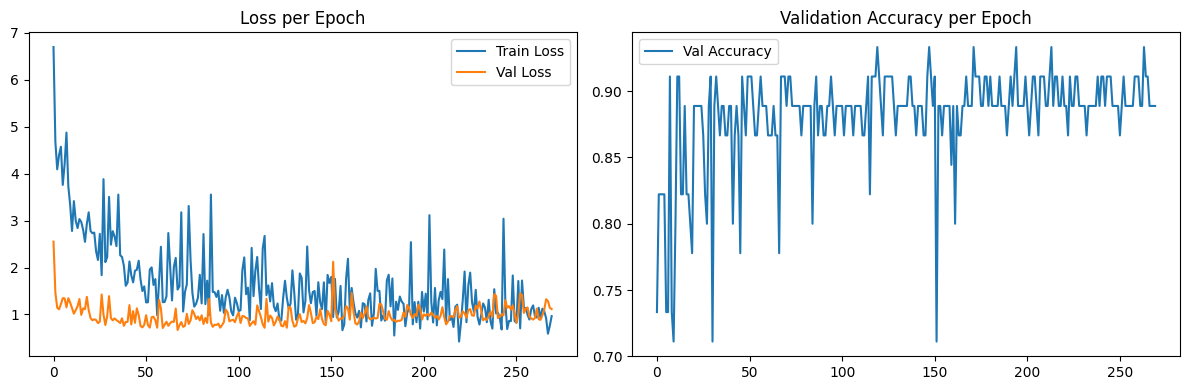

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy per Epoch")

plt.tight_layout()
plt.show()


In [110]:
model.eval()
correct = 0
total = 0
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
    total += data.y.size(0)

print(f"Test Accuracy: {correct / total:.8f}")

Test Accuracy: 0.95555556


In [126]:
from sklearn.metrics import accuracy_score
y_true = []
y_pred = []

test_loader = DataLoader(test+val, batch_size=16)

from sklearn.metrics import precision_score, recall_score, f1_score
with torch.no_grad():
    for data in test_loader:
        # Get the true labels
        y_true.extend(data.y.tolist())

        # Get the model predictions
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1).tolist()
        y_pred.extend(pred)

assert len(y_true) == len(y_pred), "Inconsistent number of samples in y_true and y_pred"
# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)

print(f"Accuracy: {acc:.6f}")

# Print the results
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.911111
Precision: 0.919002
Recall: 0.911111
F1 Score: 0.911925


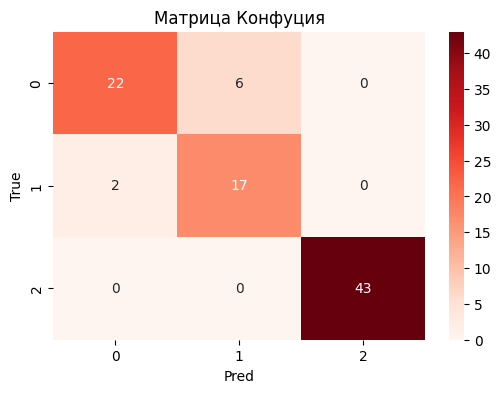

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Reds')
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Матрица Конфуция')
plt.show()

In [ ]:
### Далее неактуальное 

for epoch in range(1, 900):
    model.train()
    total_loss = 0

    for data in loader: 
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 100, Loss: 2.1461
Epoch 200, Loss: 2.0687
Epoch 300, Loss: 2.0643
Epoch 400, Loss: 1.7912
Epoch 500, Loss: 1.7448
Epoch 600, Loss: 2.1298
Epoch 700, Loss: 2.1570
Epoch 800, Loss: 1.6331


In [ ]:
model.eval()
correct = 0
total = 0
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
    total += data.y.size(0)

print(f"Test Accuracy: {correct / total:.8f}")

Test Accuracy: 0.79166667


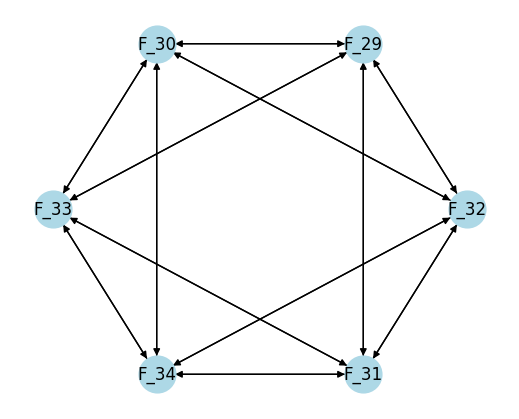

In [ ]:
testFilePath = os.getcwd() + "\\DSet\\filesK\\cube_test.m3d"
G_test = model_to_graph(testFilePath)

plt.figure(figsize=(5,4))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G_test)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G_test.nodes(data=True) if data["type"] == "face"]

nx.draw(G_test, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

In [23]:
test_graph = graph_to_data(G_test)
with torch.no_grad():
    out = model(test_graph.x, test_graph.edge_index, test_graph.batch)
    pred_class = out.mean(dim=0).argmax().item() 
    print(f"Предсказанный класс: {pred_class}")

Предсказанный класс: 0


In [24]:
test_graph

Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5])

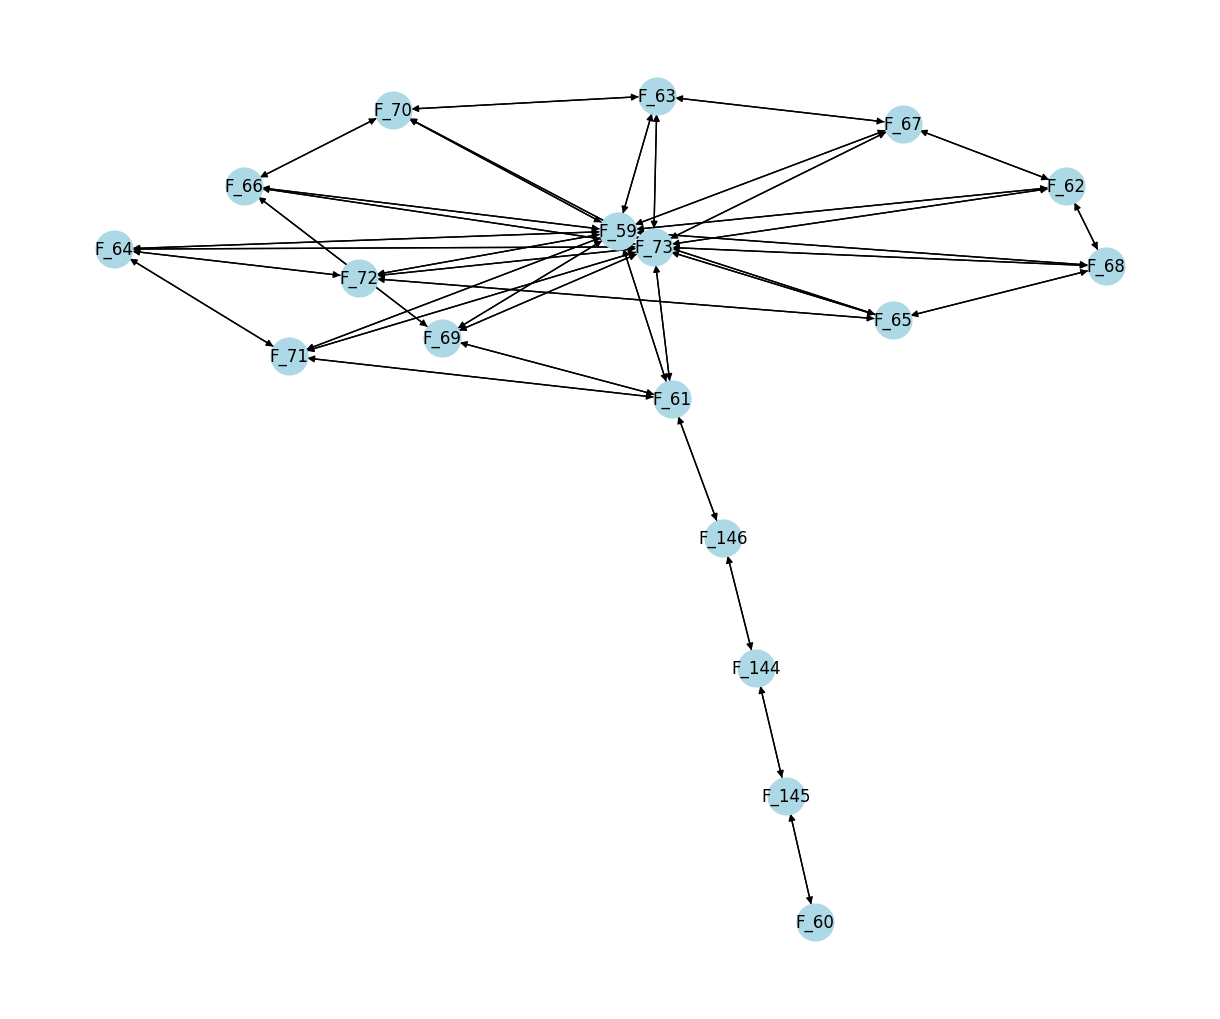

Предсказанный класс: 1


In [26]:
testFilePath = os.getcwd() + "\\DSet\\korp_73\\test\\test_1.m3d"
G_test = model_to_graph(testFilePath)

plt.figure(figsize=(12, 10))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G_test)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G_test.nodes(data=True) if data["type"] == "face"]

nx.draw(G_test, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

test_graph = graph_to_data(G_test)
with torch.no_grad():
    out = model(test_graph.x, test_graph.edge_index, test_graph.batch)
    pred_class = out.mean(dim=0).argmax().item() 
    print(f"Предсказанный класс: {pred_class}")

In [ ]:
s = face.GetDefinition()
s = s.GetSurface()
s.GetEdgesCount(0)

In [ ]:
surface = face.GetSurface()
connected = face.ConnectedFaceCollection()
Sq = surface.GetArea(1) # площадь 1 - мм, 3 - м
Borders = surface.BoundaryCount # кол-во контуров
Edges = surface.GetEdgesCount(0) # кол-во ребер в цикле (№цикла)
Box = surface.GetGabarit() # габаритный блок,:: успех, x,y,z1, x,y,z2
NormalVec = surface.GetNormal (0,0) #успех, xyz ветора нормали в заданном U,V
#surface.GetParamVMax() получить min max U,V
Type = surface.GetSurfaceParam() # тип поверхности с интерфейсом
ClosedV = surface.IsClosedV() #замкнутость по U, V
ClosedU = surface.IsClosedU()
print(surface.IsClosedU(),surface.IsClosedV()) 
#print(connected)
c = 0
#print(connected.GetCount())
for c in range(connected.GetCount()):
    conFace = connected.GetByIndex (c)
    print (conFace.GetEntity().name )
else:
    print("no connected")
    l = 0